https://github.com/TatsuyaShirakawa/poincare-embedding/blob/master/scripts/create_mammal_subtree.py

https://arxiv.org/pdf/1705.08039.pdf

In [1]:
def generate_data(root='mathematics.n.01'):
    """
    Script to generate sample DAG data using root
    """
    #INSTALL THE CORPUS WORDNET (UNCOMMENT FIRST RUN)
    #import nltk
    #nltk.download('wordnet')
    #nltk.download('omw-1.4')

    #IMPORT DEPENDENCIES
    import random
    from nltk.corpus import wordnet as wn

    #SET ROOT/TARGET AS MAMMAL(NOUN)
    target = wn.synset(root)
    print('target', target.name())

    #FIND ALL NOUNS IN WORDNET
    words = wn.words()
    nouns = set([])
    for word in words:
        nouns.update(wn.synsets(word, pos='n'))  
    print(len(nouns), 'nouns')

    #FETCH ALL HYPERNYMS WITH PATH TO TARGET
    hypernyms = []
    for noun in nouns:
        paths = noun.hypernym_paths()
        for path in paths:
            try:
                pos = path.index(target)
                for i in range(pos, len(path)-1):
                    hypernyms.append((noun, path[i]))
            except Exception:
                continue            
    hypernyms = list(set(hypernyms))
    print(len(hypernyms), 'hypernyms')

    #SHUFFLE AND SAVE ALL RELATIONSHIP TUPLES
    random.shuffle(hypernyms)
    data = [(n1.name(), n2.name()) for n1, n2 in hypernyms]
    print(len(data), 'relations')
    return data

In [20]:
data = generate_data('bird.n.01')

target bird.n.01
82115 nouns
3435 hypernyms
3435 relations


In [21]:
data[:20]

[('australian_turtledove.n.01', 'columbiform_bird.n.01'),
 ('snowy_egret.n.01', 'bird.n.01'),
 ('american_gallinule.n.01', 'gallinule.n.01'),
 ('banded_stilt.n.01', 'stilt.n.03'),
 ('plover.n.01', 'shorebird.n.01'),
 ('great_bowerbird.n.01', 'passerine.n.01'),
 ('jaeger.n.01', 'coastal_diving_bird.n.01'),
 ('blue_jay.n.01', 'new_world_jay.n.01'),
 ('new_world_jay.n.01', 'passerine.n.01'),
 ('auklet.n.01', 'aquatic_bird.n.01'),
 ('hedge_sparrow.n.01', 'passerine.n.01'),
 ('shoveler.n.02', 'anseriform_bird.n.01'),
 ('peahen.n.01', 'gallinaceous_bird.n.01'),
 ('pheasant_coucal.n.01', 'coucal.n.01'),
 ('goldfinch.n.02', 'oscine.n.01'),
 ('old_squaw.n.01', 'sea_duck.n.01'),
 ('cochin.n.01', 'domestic_fowl.n.01'),
 ('corncrake.n.01', 'aquatic_bird.n.01'),
 ('least_sandpiper.n.01', 'shorebird.n.01'),
 ('warbler.n.02', 'oscine.n.01')]

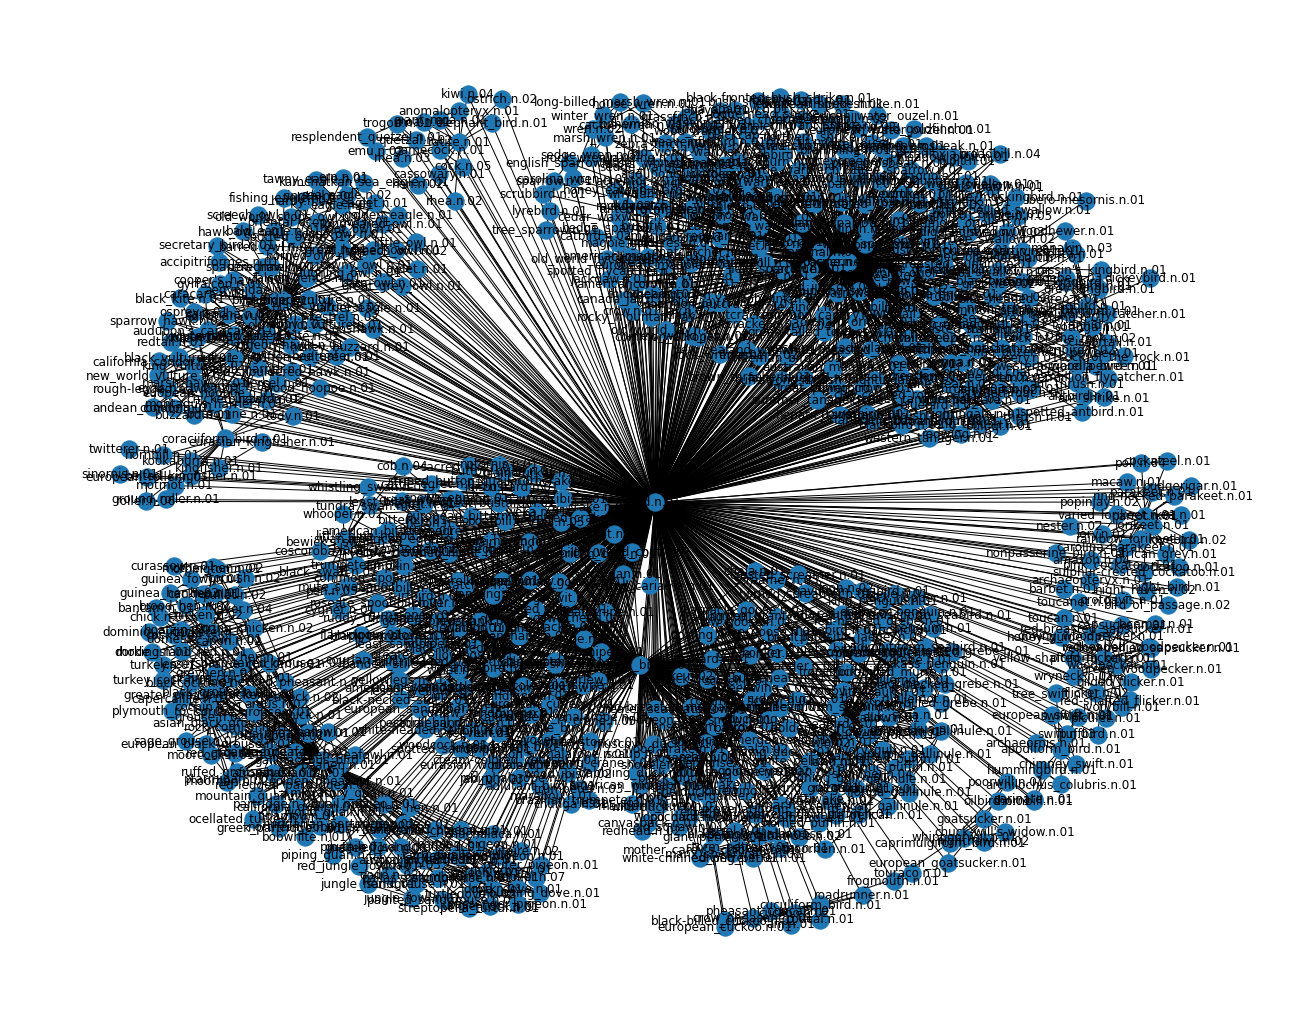

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,14))
g = nx.Graph(data)
nx.draw(g, with_labels=True)

In [23]:
from gensim.models.poincare import PoincareModel

#MODEL TRAINING
model = PoincareModel(data, size=50, negative=10)  #<---
model.train(epochs=30)                             #<---

#FETCH VECTORS AND STORE
vectors = {}
keys = model.kv.index_to_key
for k in keys:
    vectors[k] = model.kv.get_vector(k)

#STACKING EMBEDDINGS TO A NDARRAY
embeddings = np.stack(vectors.values())

print(len(keys),'keys')
print(embeddings.shape[0], 'embeddings')
print(embeddings.shape[1], 'dimensions')

872 keys
872 embeddings
50 dimensions


/opt/homebrew/Caskroom/miniforge/base/envs/nlp_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [73]:
#[i for i in keys if i.find('duck')!=-1] #Find variants of generic groups

print('owl vs hawk:', model.kv.similarity('owl.n.01','hawk.n.01'))
print('eagle vs bald_eagle:', model.kv.similarity('eagle.n.01','bald_eagle.n.01'))
print('golden_eagle vs bald_eagle:', model.kv.similarity('golden_eagle.n.01','bald_eagle.n.01'))
print('owl vs barn_owl:', model.kv.similarity('owl.n.01','barn_owl.n.01'))
print('barn_owl vs spotted_owl:', model.kv.similarity('barn_owl.n.01','spotted_owl.n.01'))
print('barn_owl vs mandarin_duck:', model.kv.similarity('barn_owl.n.01','mandarin_duck.n.01'))

owl vs hawk: 0.31635084567961813
eagle vs bald_eagle: 0.8757754918787964
golden_eagle vs bald_eagle: 0.8758848440323967
owl vs barn_owl: 0.6982827095728305
barn_owl vs spotted_owl: 0.738832541978296
barn_owl vs mandarin_duck: 0.1329321668369148


In [70]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(3)
components = pca.fit_transform(embeddings)

plot_df = pd.DataFrame(components, 
                       columns=['component1', 'component2', 'component3'], 
                       index=keys)

plot_df = plot_df.head(100)   #<--- PLOTTING ONLY 100 VECTORS FROM THIS DATA

px.scatter_3d(plot_df, 
              x='component1', y='component2', z='component3', 
              text=plot_df.index, opacity=0.5, height=900, width=900)